# Semantic Segmentation with AutoEncoder

Semantic Segmentation is the task of assigning a class label to every single pixel of an input image. It has three steps:

- Classifying: Classifying a certain object in the image.
- Localizing: Finding the object and drawing a bounding box around it.
- Segmentation: Grouping the pixels in a localized image by creating a segmentation mask. (Our notebook focuses on this)

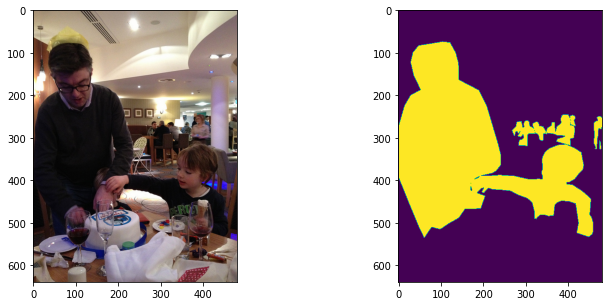

In [1]:
!pip install pycocotools

import matplotlib.pyplot as plt
import numpy as np
import random
import skimage.io as io
import torch
import torchvision.transforms.functional as TF
from pathlib import Path
from typing import Any, Callable, List, Optional, Tuple
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
from tqdm.auto import tqdm
%matplotlib inline

  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=275336 sha256=a2cf979f3a1335685dbd28e49df6574d4fff064f3ec2e822afedafeec73d08d6
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [2]:
ROOT_PATH = Path("/kaggle/input/coco-2017-dataset/coco2017/")
BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)
train_annotations = COCO(ROOT_PATH / "annotations/instances_train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/instances_val2017.json")
cat_ids = train_annotations.getCatIds(supNms=["person", "vehicle"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
train_img_ids = list(set(train_img_ids))
valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
valid_img_ids = list(set(valid_img_ids))
i = 22
img_data = train_annotations.loadImgs(train_img_ids[i])
ann_ids = train_annotations.getAnnIds(imgIds=img_data[0]['id'], catIds=cat_ids, iscrowd=None)
anns = train_annotations.loadAnns(ann_ids)
mask = np.max(np.stack([train_annotations.annToMask(ann) * ann["category_id"] for ann in anns]), axis=0)

loading annotations into memory...
Done (t=28.46s)
creating index...
index created!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [3]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        if self.transform is not None:
            return self.transform(img, mask)
        return img, mask

def train_transform(
    img1: torch.LongTensor, 
    img2: torch.LongTensor
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
    return img1, img2

train_data = ImageData(train_annotations, train_img_ids, cat_ids, ROOT_PATH / "train2017", train_transform)
valid_data = ImageData(valid_annotations, valid_img_ids, cat_ids, ROOT_PATH / "val2017", train_transform)

train_dl = DataLoader(
    train_data,
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
)

valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE, 
    shuffle=False, 
    drop_last=False, 
    num_workers=2,
    pin_memory=True,
)

In [4]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

loss_fn = nn.MSELoss()   
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 2

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for images, masks in tqdm(train_dl, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = autoencoder(images.float())
        loss = loss_fn(outputs, images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    autoencoder.eval()
    valid_loss = 0.0

Epoch 1/2:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 17733.8686


Epoch 2/2:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 17731.3557
